# Densidad de Probabilidad a partir de datos

En este ejemplo, se utilizarán los métodos vistos en la materia para aproximar la densidad de probabiidad $\rho(x)$ de un conjunto de datos $X$ unidimensionales.

## Solucionador de la ecuación Ax=b

Primero se importarán las paqueterías que se utilizarán y se escribiran los códigos auxiliares para encontrar la factorización
$$
A=PLU
$$
de una matriz $A \in \mathbb{R}^{m \times m}$ invertible.

In [89]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
#plt.rcParams['text.usetex'] = True

In [90]:
def Perm_Row(A,i,j):
    B = np.copy(A)
    A[i], A[j] = B[j], B[i]

    return A

def Perm_Col(A,i,j):
    B = np.copy(A)
    A[:,i], A[:,j] = B[:,j], B[:,i]

    return A

In [91]:
def Ind_max(A,ind):
    return np.argmax(np.abs(A[:,ind][ind:]))+ind

A continuación se escribe el código de la función PLU, la cuál toma como argumento a la matriz $A$ y regresa las matrices $P,L,U \in \mathbb{R}^{m \times m}$, tales que
$$
PA = LU.
$$

In [92]:
def PLU(A):
    m,n = np.shape(A)
    P = np.eye(n)
    L = np.zeros((n,n))
    U = np.copy(A)

    if m != n:
        return print("La matriz no es cuadrada.")

    for j in range(n-1):
        index = Ind_max(U,j)

        L = Perm_Row(L,j,index)
        U = Perm_Row(U,index,j)
        P = Perm_Row(P,index,j)

        for i in range(j+1,n):

            L[i][j] = U[i][j]/U[j][j]
            U[i] = U[i] - L[i][j]*U[j]

    L += np.eye(n)

    return P,L,U

Se prueba la factorización calculando
$$
||PA - LU||
$$
mediante la función $\textit{norm}$ de la paquetería linalg de numpy.

In [93]:
N = 500
M = 10*np.random.rand(N,N)

P_2,L_2,U_2 = PLU(M)

print("El error en PLU es: ", np.linalg.norm(P_2@M - L_2@U_2))

El error en PLU es:  5.0572971210704084e-12


Se escriben dos funciones auxiliares. La primera denominada $\textit{Solv\_L}$ encuentra la solución a la ecuación
$$
Lx=b,
$$
donde $L$ es una matriz triangular inferior.
La segunda función, denominada $\textit{Solv\_U}$, encuentra la solución a la ecuación
$$
Ux=b,
$$
donde $U$ es una matriz triangular superior.

In [94]:
def Solv_L(L,b):
    n = len(b)
    y = np.zeros(n)

    for i in range(n):

        y[i] = b[i]
        for k in range(i):
            y[i]-=L[i][k]*y[k]
        y[i] =y[i]/L[i][i]

    return y

In [95]:
def Solv_U(U,b):
    n = len(b)
    y = np.zeros(n)

    for i in range(n-1,-1,-1):
        y[i] = b[i]

        for k in range(i+1,n):
            y[i] -= U[i][k]*y[k]

        y[i] = y[i]/U[i][i]
    return y

Por último, se escribe la función $\textit{Solv\_PLU}$, la cual encuentra la solución a la ecuación
$$
Ax=b.
$$

Para esto, primero se encuentran las matrices $P,L,U$, tales que $PA=LU$. Después se considera la ecuación
$$
PAx=Pb;
$$
esta ecuación implica que
$$
LUx=Pb.
$$

Para encontrar a $x$, se soluciona primero la ecuación
$$
Ly=b,
$$
usando $\textit{Solv\_L}$ y luego la ecuación
$$
Ux=y,
$$
usando $\textit{Solv\_U}$.

In [96]:
def Solv_PLU(A,b):
    P,L,U = PLU(A)
    b = P@b

    y = Solv_L(L,b)
    x = Solv_U(U,y)

    return x

A continuación, se definen funciones que se utilizarán para probar la eficiencia del solucionador mediante el error relativo y absoluto definidos por
$$
err_{abs} = ||\tilde{x} -x||
$$
y
$$
err_{rel}\frac{||\tilde{x} -x||}{||x||},
$$
donde $x$ es la solución teórica y $\tilde{x}$ la solución obtenida mediante el algoritmo.

In [97]:
def Rand_Prob(n):
    M = 100*np.random.randn(n,n)
    x = 100*np.random.randn(n)
    M = M.T@M
    b = M@x

    return M,b,x

In [98]:
def Err(solution,approx):
    Err_abs = la.norm(solution-approx)
    Err_rel = Err_abs/la.norm(solution)
    return Err_abs,Err_rel

In [99]:
M,b_0,x_teo = Rand_Prob(100)

x_sol = Solv_PLU(M,b_0)

Err(x_teo,x_sol)

(2.1536719844805422e-10, 2.120892301417752e-13)

## Aproximación Polinomial

En esta sección se escribirán las funciones que permitirán encontrar un polinomio $P(x)$ de grado $n$ que mejor aproxime al conjunto de puntos
$$
\{(x_i, y_i) \in \mathbb{R}^2 : 1 \leq i \leq m \}.
$$
Esto quiere decir que para cualquier polinomio $Q(x)$ de grado $n$, se cumple que
$$
\left( \sum_{i=1}^m (P(x_i) - y_i)^2 \right)^{1/2} \leq
\left( \sum_{i=1}^m (Q(x_i) - y_i)^2 \right)^{1/2}.
$$

Si
$$
P(x) = \sum_{k=0}^n a_k x^k,
$$
se tiene que
$$
\left( \sum_{i=1}^m (P(x_i) - y_i)^2 \right)^{1/2} = ||Va-y||_2,
$$
donde $a = (a_0, a_1, ..., a_n)^T \in \mathbb{R}^{n+1}$, $y = (y_1, y_2, ..., y_m)^T$ y $V$ es la matriz de Vandermonde cuyas entradas son
$$
V_{ij} = x_i^j.
$$
De esta forma, encontrar el polinomio $P(x)$ de grado $n$ que mejor aproxima los puntos dados es equivalente a encontrar el vector $a$ de coeficientes que cumpla que
$$
||Va-y||_2 \leq ||Vx - y||_2,
$$
para todo $x \in \mathbb{R}^{n+1}$.

Como se vio en clase, el vector $a$ cumple esto es el vector solución a las ecuaciones normales
$$
V^T V a = V^T y.
$$

### Código para encontrar los coeficientes

Primero se definirá la función $\textit{Vandermonde}$, que tomará como argumento a los $x_i$ y el grado del polinomio deseado. Esta función regresará la matriz de Vandermonde $V$.

In [100]:
def Vandermonde(X,grado):
    m = len(X)
    V = np.zeros((m,grado+1))
    V[:,0] = np.ones(m)
    for j in range(grado+1):
        V[:,j] = X**j
    return V

A continuación, se escribirá la función que obtiene los coeficientes del polinomio $P(x)$ deseado, resolviendo las ecuaciones normales con la función solucionador creada.

In [101]:
def Coef_pol(data, grado):
    V = Vandermonde(data[:,0], grado)

    a = Solv_PLU(V.T@V,V.T@data[:,1])

    return a

Creamo ahora una función que tome como argumentos el vector que contiene los coeficienes de un polinomio $a=(a_0, a_1, ..., a_n)$, un valor real $x$ y que regrese $P(x)$

In [102]:
def Eval_pol(a,x):
    suma=0
    n = len(a)
    for i in range(n):
        suma+=a[i]*(x**i)
    return suma

Nótese que esta función permitirá definir una función que solo dependa de $x$ mediante la igualdad $P(x) = Eval\_pol(a,x)$, para cada $a$ fijo.

## Integración Numérica

Haciendo uso de la aproximación polinomial, se aproximará la integral de una función $f(x)$, integrando el polinomio que mejor se aproxima a $f$. Es decir que si
$$
f(x) \approx P(x),
$$
se sigue que
$$
\int_a^b f(x) \approx \int_a^b P(x).
$$

### Método de Simpson

El algoritmo más común para la integración numérica, es el método de Simpson, el cuál consiste en interpolar un polinomio de grado 3 a la función $f(x)$ en el intervalo $[a,b]$. Para obtener una interpolación, en lugar de una aproximación Polinomial, se debe cumplir la ecuación
$$
Va=y,
$$
por lo que $V$ tiene que ser cuadrada, es decir, el número de puntos de la forma $(x_i,y_i)$ que se van a utilizar es 4. Los puntos a interpolar usuales son
$(a, f(a)), ((b-a)/3, f((b-a)/3)), (2(b-a)/3, f(2(b-a)/3))$ y $(b, f(b))$.

De esta forma, mediante el algoritmo de Vandermonde se obtiene $a=(a_0,a_1,a_2,a_3)^T$ tal que
$$
P(x_i) = a_0 + a_1x_i + a_2 x_i^2 + a_3x_i^3 = f(x_i),
$$
lo que implica que
$$
\int_a^b f(x) \approx
a_0(b-a) + a_1 \frac{b^2 - a^2}{2} + a_2 \frac{b^3 - a^3}{3} + a_3 \frac{b^4 - a^4}{4}.
$$

#### Código para la integración numérica por el método de Simpson

A continuación se escribe el código para la integración numérica por el método descrito arriba. Primero se escribirá una función auxiliar que genere los 4 puntos necesarios para la interpolación. Esta función tomará como argumentos a la función $f$ y a los límites de integración $a$ y $b$; la función regresará los datos de la forma que requiere nuestra función de Vandermonde.

In [103]:
def PuntInt(f,a,b):
    xdatos = np.linspace(a,b,4)
    ydatos = np.zeros(4)
    ydatos = f(xdatos)
    datos = np.vstack((xdatos,ydatos))
    datos = datos.T
    return datos

A continuación se escribirá la función de integración numérica, cuyos argumentos son los mismos que la función anterior. Esta función utilizará la función de aproximación de Vandermonde para obtener los coeficientes y regresará el valor de la integral.

In [104]:
def IntSimp(f,a,b):
    datos = PuntInt(f,a,b)
    c = Coef_pol(datos,3)
    integ = 0
    for i in range(4):
        integ += (c[i]*(b**(i+1)-a**(i+1)))/(i+1)
    return integ

### Método de Simpson compuesto

Si el intervalo $[a,b]$ es muy grande, la interpolación polinomial de la función $f$ por medio de un polinomio de grado 3, no será una buena aproximación. Por lo que la integral diferirá mucho del valor teórico.

Una forma de lidiar con esto, es haciendo una partición regular del intervalo $[a,b]$ en $n$ subintervalos de longitud $(b-a)/n$ y en cada uno de estos subintervalos inetgrar numericamente la función mediante el método de Simpson. A este algoritmo se le denomina Simpson compuesto.

Si la partición está definida por el conjunto
$$
\{a = t_0, t_1, ..., t_n=b \},
$$
la siguiente ecuación resume el algoritmo de Simpson compuesto
$$
\int_a^b f \approx \sum_{i=1}^n \int_{t_{i-1}}^{t_i} P_i,
$$
donde $P_i(x)$, es el polinomio de grado 3 que interpola a $f$ en el subintervalo $[t_{i-1}, t_i]$.

#### Código para el algoritmo de Simpson compuesto

A continuación se escribe el código que obtiene la integral numérica de $f$ en el intervalo $[a,b]$ mediante el algoritmo de Simpson compuesto. Esta función tomará como argumentos a la función $f$, a los límites de integación $a,b$ y al número de subintervalos $n$ en los cuáles se subdividirá el intervalo $[a,b]$.

In [105]:
def Simp_comp(f,a,b,n):

    # Obtención de la partición
    Part = np.linspace(a,b,n+1)

    # Variable que guardará el valor de la integral
    integ = 0

    # Ciclo para integrar en cada subintervalo
    for i in range(n):
        integ += IntSimp(f,Part[i],Part[i+1])

    # Regresamos el valor de la integral
    return integ

## Ejemplo de integración numérica

Para probar todos nuestros algoritmos en conjunto, se calculará la integral de la función $f(x) = e^{-x^2}$ en todo $\mathbb{R}$, la cuál cumple que
$$
\int_{-\infty}^{\infty} e^{-x^2} dx = \sqrt{\pi}.
$$

Primero definiremos a nuestra función $f(x) = e^{-x^2}$ en python y luego calcularemos la integral.

In [106]:
def g(x):
    return np.exp(-x**2)

Ahora calcularemos la integral numérica de esta función y para evaluar el desempeño de la misma, se mostrará el error asociado a la misma

In [107]:
#Límites de integración
M=15
#Número de subintervalos
sub=10**2

int_exp = Simp_comp(g,-M,M,sub)

print("El error relativo asociado a la integral numérica es:",
      np.abs(int_exp - np.sqrt(np.pi))/np.sqrt(np.pi))

El error relativo asociado a la integral numérica es: 2.0908439756022308e-13


In [108]:
M = np.linspace(10, 1000, 30)
subinter = np.arange(2, 30*30+2, 30)

z = np.zeros((30,30))
for i in range(30):
    for j in range(30):
        z[i][j] = np.abs(Simp_comp(g, -M[i], M[i], subinter[j]) - np.sqrt(np.pi))/np.sqrt(np.pi)

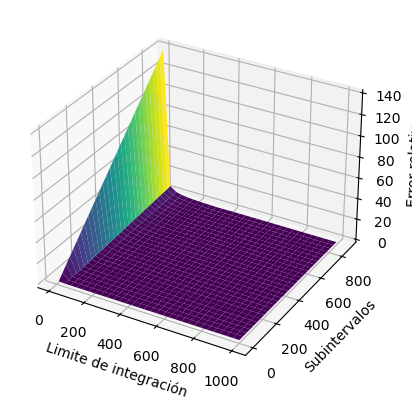

In [109]:
M, subinter = np.meshgrid(M, subinter)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(M, subinter, z, cmap='viridis')
ax.set_xlabel('Limite de integración')
ax.set_ylabel('Subintervalos')
ax.set_zlabel('Error relativo')
plt.show()

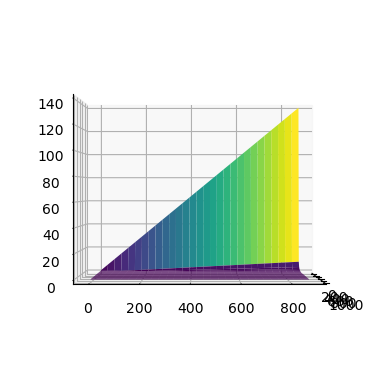

In [110]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(M, subinter, z, cmap='viridis')
ax.view_init(elev=0, azim=-0)

## Funciones integrales por medio de la integración numérica

Una función integral es aquella función definida en términos de una integral. El ejemplo más representativo de estas funciones, es el del logaritmo natural, el cuál está definido por
$$
ln(x) = \int_1^x \frac{1}{t} dt.
$$

A partir de la integral numérica es posible evaluar estas funciones integrales. A continuación se definirá el logaritmo natural mediante la evaluación de la integral numérica y se comparará con la función logaritmo natural de pyhton mediante una gráfica.

In [111]:
def h(x):
    return 1/x

In [112]:
def Log_nat(x):
    return Simp_comp(h,1,x,10**2)

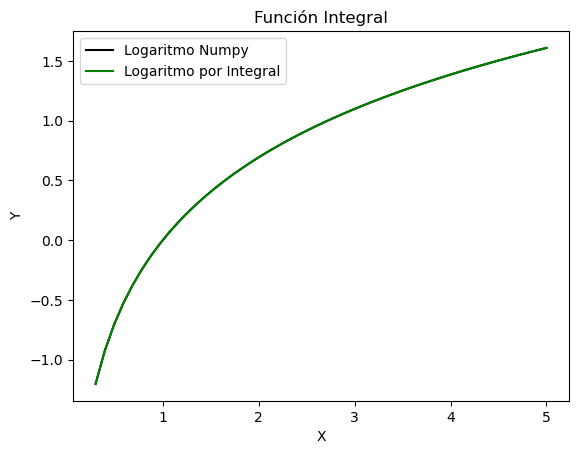

In [113]:
NumPunt = 50
lim_inf=0.3
lim_sup=5
Dom = np.linspace(lim_inf,lim_sup,NumPunt)

Y1 = np.log(Dom)

Y2 = np.zeros(NumPunt)
for i in range(NumPunt):
    Y2[i] = Log_nat(Dom[i])

plt.plot(Dom,Y1, c='k', label="Logaritmo Numpy")
plt.plot(Dom,Y2, c='g', label="Logaritmo por Integral")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Función Integral")


plt.legend()

plt.show()

## Obtención de densidad de probabilidad de la función np.random

Por último, utilizaremos todo lo anterior para encontrar la densidad de probabilidad de la función np.random.normal de numpy. De antemano sabemos que la distribución de estos puntos es la distribución normal, por lo que su media estará en cero.

Para esto, se tomará un muestreo de la función, posteriormente convertiremos el muestreo en un histograma del cual se obtendrán puntos a los cuáles se les aproximará un Polinomio, el cuál se convertirá en nuestra función de densidad. A continuación, se integrará numéricamente este polinomio en el intervalo $[a,b]$ para normalizar el polinomio, de tal forma que la integral sobre el intervalo sea uno. Los límites son tales que $a$ es el mínimo valor de la distribución y $b$ el máximo.

Por último, para ver si nuestra densidad obtenida modela suficientemente bien a la campana gaussiana, se obtendrá la media $\mu$, mediante la condición

$$
\int_0^{\mu} \rho(x)\ dx = 0.5.
$$

Primero se obtiene el muestreo. Después, utilizando la función histogram de numpy, se definirá una partición del intervalo $[a,b]$ y se contabilizará el número de elementos del muestreo que hay en cada subintervalo

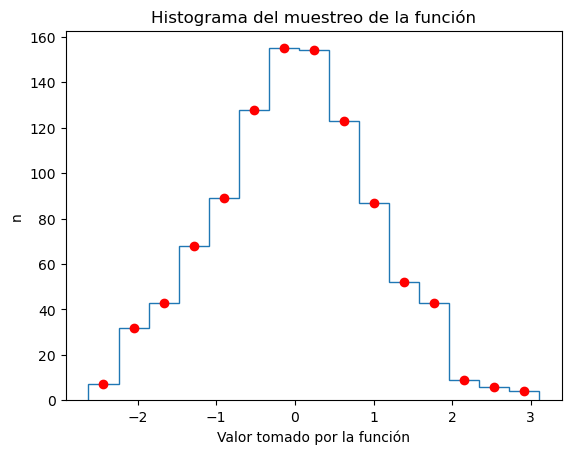

In [114]:
Sample = np.random.normal(size=1000)

#Y definirá la frecuencia en cada subintervalo
#X es el conjunto que define la partición
#el argumentos bins se refiere al número de subintervalos deseados
subinter = 15
Y,X = np.histogram(Sample, bins=subinter)

Dom = np.zeros(subinter)
for i in range(subinter):
    Dom[i] = (X[i] + X[i+1])/2

# Visualización del histograma

plt.stairs(Y,X)

plt.xlabel("Valor tomado por la función")
plt.ylabel("n")
plt.title("Histograma del muestreo de la función")
plt.scatter(Dom,Y, color='r', label="Puntos a aproximar")

plt.show()

In [115]:
dat = np.vstack((Dom,Y))
dat = dat.T
grado_aprox=8

c = Coef_pol(dat,grado_aprox)

def Pol_norm(x):
    return Eval_pol(c,x)


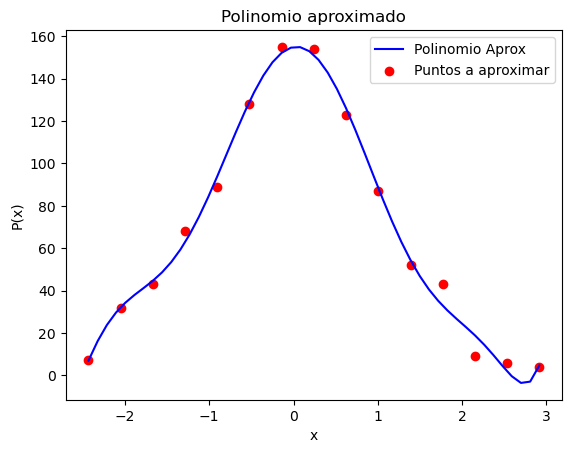

In [116]:
a_0=np.min(Dom)
b_0=np.max(Dom)

t = np.linspace(a_0,b_0,50)

plt.plot(t,[Pol_norm(x) for x in t], color='b', label="Polinomio Aprox")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.title("Polinomio aproximado")
plt.scatter(Dom,Y, color='r', label="Puntos a aproximar")
plt.legend()

plt.show()

In [117]:
α = Simp_comp(Pol_norm,a_0,b_0,300)

In [118]:
def dist_norm(x):
    return Pol_norm(x)/α

In [119]:
Simp_comp(dist_norm,a_0,b_0,300)

0.9999999999986228

In [123]:
def lambda_dist(x):
    return x*dist_norm(x)

In [126]:
# Encontrar la media
μ = 0

Simp_comp(lambda_dist, a_0, b_0, 500)

-0.029941325370671488

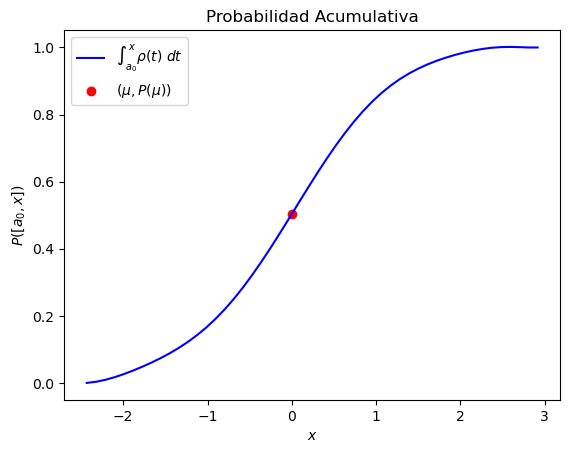

In [121]:
t = np.linspace(a_0,b_0,50)

plt.plot(t,[Simp_comp(dist_norm, a_0, x, 300) for x in t], color='b',
         label=r"$\int_{a_0}^x \rho(t)\ dt$")
plt.scatter(μ,
            Simp_comp(dist_norm,a_0,μ,300),
            color='r', label=r"$(\mu, P(\mu))$")
plt.xlabel(r"$x$")
plt.ylabel(r"$P([a_0,x])$")
plt.title("Probabilidad Acumulativa")
plt.legend()

plt.show()

In [122]:
# El intervalo de confianza para el 95% de la población
# debe ser [μ-2σ, μ+2σ] y teóricamente se tiene que
# σ=1, μ=0

d = 1.94
Simp_comp(dist_norm,μ-d,μ+d,300)

0.9469030316061505